# Parallelisation d'un algorithme de boosting

Jacques Song et Tristan Loisel, rendu le 03/02/2020 

Eléments logiciels pour traitement de données massives

Dans ce notebook, nous présentons un algorithme de boosting, codé en `python`, que nous parallelisons à l'aide du package `ray`.

## Import des packages nécessaires

In [1]:
import ray
import time
import numpy as np
import sklearn as sk
from sklearn import tree
from sklearn.linear_model import RidgeClassifier
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Construction des sets d'entraînement et de test

Nous avons choisi ici de travailler avec les données "mnist_784", qui contiennent des chiffres manuscrits.

In [2]:
X, y = fetch_openml(name="mnist_784", return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, random_state=0)

9


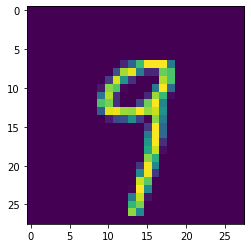

In [3]:
plt.imshow(np.reshape(X_train[0], (28, 28)))
print(y_train[0])

## L'algorithme:

L'algorithme que nous implémentons est le suivant, il a été présenté par Aleksandar LAZAREVIC et Zoran OBRADOVIC dans *Boosting Algorithms for Parallel and Distributed Learning, Distributed and Parallel Databases, 11, 203–229, 2002*.


 Entrée: un set de données labellisées $S = \{(X_i,Y_i)\}_{i \in \{1,...,n\}}$, avec pour chaque $i$, $y_i \in \{0,...,9\}$

Initialisation: création 

&nbsp;&nbsp;&nbsp;-d'un ensemble $B=\{(i,y), i \in \{1,...,n\}, y_i \neq y\}$

&nbsp;&nbsp;&nbsp;-d'une densité de probabilité sur S, $\mu_1$, telle que $\mu_1(i)=\frac{1}{n}$ pour chaque $i \in \{1,...,n\}$.

Pour chaque $t \in \{1,...,T\}$:

&nbsp;&nbsp;&nbsp;Pour chaque processeur $j \{1,...,J\}$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Tirer un échantillon à partir de la densité $\mu_t$
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Entraîner un prédicteur $P_{t,j}$ en utilisant le processeur $j$
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Calculer sa prédiction $h_{t,j}$ de ce prédicteur
 
Créer le prédicteur $h_t$ tel que: $h_t(i) = max\{h_{t,j}(i), j \in \{1,...,J\}$

Calculer la perte de $h_t$: $L_t = \frac{1}{2} \sum_{(i,y) \in B} \mu_t (i,y) (1-h_t (x_i, y_i)+h_t (x_i,y))$

Calculer $\mu_{t+1}(i,y) = \frac{\mu_{t}(i,y)}{C_t} \beta_t^{w_{t,i}}$ où $\beta_t = \frac{L_t}{1 - L_t}$, $w_{t,i} =  \frac{1}{2}(1-h_t (x_i, y)+h_t (x_i,y_i))$ et $C_t$ est une constante de normalisation.

Retourner $h = argmax_{y \in \{0,...,9\}} \sum_{t \in \{1,...,T\}} log(\frac{1}{\beta_t})h_t(.,y)$



## Définition de quelques fonctions utiles

In [4]:
def resample(probs, sample_size, nbr_samples):
    counts_array = np.random.multinomial(sample_size, probs, size=nbr_samples)
    samples = []
    labels = []
    for counts in counts_array:
        samples.append(sample(counts, X_train))
        labels.append(sample(counts, y_train))
    return samples, labels

def sample(counts, data):
    sample = []
    for index, count in enumerate(counts):
        for _ in range(count):
            sample.append(data[index])
    return np.array(sample)

@ray.remote
def train_weak_learner(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

@ray.remote
def make_hypothesis(model):
    def fun(X, y):
        return int(model.predict([X])==y)
    return fun

def merge_hypothesis(hypotheses):
    def fun(X, y):
        return max([hypotheses[k](X, y) for k in range(P)])
    return fun

## Définition des paramètres

In [5]:
N = np.shape(X_train)[0]
T = 1
P = 10

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Implémentation de l'algorithme

In [6]:
ray.init(num_cpus=P)

2020-02-02 20:06:35,723	INFO resource_spec.py:212 -- Starting Ray with 3.66 GiB memory available for workers and up to 1.84 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-02 20:06:36,108	INFO services.py:1093 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.31',
 'redis_address': '192.168.1.31:30824',
 'object_store_address': '/tmp/ray/session_2020-02-02_20-06-35_707227_84392/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-02_20-06-35_707227_84392/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-02-02_20-06-35_707227_84392'}

Initialize boosting weights

In [7]:
D = []
D.append(np.ones(shape=(N,), dtype=np.float32)/N)

In [8]:
X_samples, y_samples = resample(D[-1], sample_size=N, nbr_samples=P)

In [9]:
B_X = []
B_y = []
for X, y in zip(X_train, y_train):
    for char in classes:
        if char != y:
            B_X.append(X)
            B_y.append(char)

In [10]:
def loss(hypothesis, D):
    epsilon = 0
    for i in range(9*N):
        epsilon += D[i//9]*(1 - hypothesis(X_train[i//9], y_train[i//9]) + hypothesis(X_train[i//9], B_y[i]))
    return .5 * epsilon

Heart of the training

In [11]:
learners_list = []
for t in range(T):
    fitted_models_id = []
    hypotheses_id = []
    weak_learners = [tree.DecisionTreeClassifier() for k in range(P)]
    for k in range(P):
        model_id = train_weak_learner.remote(weak_learners[k], X_samples[k], y_samples[k])
        fitted_models_id.append(model_id)
        hypotheses_id.append(make_hypothesis.remote(model_id))
    fitted_models = ray.get(fitted_models_id)
    hypotheses_list = ray.get(hypotheses_id)
    hypothesis = merge_hypothesis(hypotheses_list)
    learners_list.append(hypothesis)

In [12]:
loss0 = loss(hypothesis, D[-1])

loss0

0.8799999803304672

In [13]:
res = fitted_models[0].predict(X_test[:1000])
print(classification_report(y_test[:1000], res))

              precision    recall  f1-score   support

           0       0.36      0.30      0.33        91
           1       0.53      0.69      0.60        96
           2       0.27      0.31      0.29        91
           3       0.34      0.39      0.37       103
           4       0.43      0.53      0.47        97
           5       0.11      0.10      0.10        84
           6       0.38      0.22      0.28       106
           7       0.41      0.45      0.43       116
           8       0.19      0.20      0.20       123
           9       0.35      0.26      0.30        93

    accuracy                           0.34      1000
   macro avg       0.34      0.34      0.34      1000
weighted avg       0.34      0.34      0.34      1000



In [14]:
count = 0
for X, y in zip(X_test[:100], y_test[:100]):
    count += hypothesis(X, y)